# Training Ontime Prediction Model

# Set Up ADB Connection

In [1]:
import os
import oci 
from oci.vault import VaultsClient
from oci.secrets import SecretsClient
import base64

#loading up oci conifg
config = oci.config.from_file(
     "~/.oci/config")

#define a method to decode Vault.Secrets
def decode_secret(config, secret_id): 
    """ Given a config file and a secret_id this function 
    will decode a given secret
    """
    
    secrets_client = oci.secrets.SecretsClient(config)
    secret_bundle = secrets_client.get_secret_bundle(secret_id)
    base64_Secret_content = secret_bundle.data.secret_bundle_content.content
    base64_secret_bytes = base64_Secret_content.encode('ascii')
    base64_message_bytes = base64.b64decode(base64_secret_bytes)
    return base64_message_bytes.decode('ascii')


#using sdk to load uri as a Secret from Oracle Vault, passing secret's OCID as argument
uri = decode_secret(config, "ocid1.vaultsecret.oc1.iad.amaaaaaavgi4n5aaab3ta73bxtz4qevfozaem72dzwa4n2wr7utpqvzg5e5q")
os.environ['TNS_ADMIN'] = "/home/datascience/prod/ADB/DBTracing"

In [2]:
from sqlalchemy import create_engine
import pandas as pd

# Make a connection to the Engine and run a query
engine = create_engine(uri)
package_table = pd.read_sql_table(table_name='package', con=engine, schema='adrien')
package_table.head()

/opt/conda/lib/python3.6/site-packages/sqlalchemy/dialects/oracle/base.py:1376: SAWarning: Oracle version (19, 5, 0, 0, 0) is known to have a maximum identifier length of 128, rather than the historical default of 30. SQLAlchemy 1.4 will use 128 for this database; please set max_identifier_length=128 in create_engine() in order to test the application with this new length, or set to 30 in order to assure that 30 continues to be used.  In particular, pay close attention to the behavior of database migrations as dynamically generated names may change. See the section 'Max Identifier Lengths' in the SQLAlchemy Oracle dialect documentation for background.
  % ((self.server_version_info,))


,package_id,longitude,latitude,transit_time,status,dest_long,dest_lat,time_stamp
0,67403,30.245607,-97.731024,603.177273,0,30.403742,-97.701395,2020-11-18 17:58:17
1,67403,30.247973,-97.734920,606.049545,0,30.403742,-97.701395,2020-11-18 17:58:20
2,67403,30.244317,-97.722106,608.921818,0,30.403742,-97.701395,2020-11-18 17:58:23
3,67403,30.244658,-97.723116,611.794091,0,30.403742,-97.701395,2020-11-18 17:58:25
4,67403,30.244709,-97.723379,614.666364,0,30.403742,-97.701395,2020-11-18 17:58:28


# Using Accelerated Data Science to train Ontime Prediction Model

In [3]:
import pandas as pd
from sklearn.utils import Bunch
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor



import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.common.model import ADSModel
from ads.catalog.model import ModelSummaryList, ModelCatalog
from ads.catalog.project import ProjectSummaryList, ProjectCatalog
from ads.catalog.summary import SummaryList
from ads.common.model_artifact import ModelArtifact
from sklearn.utils import Bunch

In [4]:
df = pd.read_sql_query('SELECT longitude, latitude, transit_time, status, dest_long, dest_lat FROM adrien.package order by time_stamp', con=engine)

In [5]:
df.head()

,longitude,latitude,transit_time,status,dest_long,dest_lat
0,30.214831,-97.752487,3.401107,0,30.166594,-97.748047
1,30.247756,-97.734141,6.802214,0,30.166594,-97.748047
2,30.247635,-97.735719,10.203321,0,30.166594,-97.748047
3,30.194573,-97.767740,13.604428,0,30.166594,-97.748047
4,30.194930,-97.767379,17.005535,0,30.166594,-97.748047


In [6]:
ds = DatasetFactory.from_dataframe(df)
ds = ds.set_target('transit_time')
transformed_ds = ds.auto_transform()
transformed_ds.show_in_notebook()

Accordion(children=(HTML(value='<h3>Type: RegressionDataset</h3><h3>4,274 Rows, 6 Columns</h3><h4>Column Types…

In [7]:
transformed_ds = transformed_ds[['longitude','latitude','transit_time']]
train, test = transformed_ds.train_test_split(test_size=0.3)
X_train = train.X.values
y_train = train.y.values

X_test = test.X.values
y_test = test.y.values


knbr = KNeighborsRegressor(n_neighbors = 5).fit(X_train, y_train)
rdfr = RandomForestRegressor(max_depth=1000, random_state=10).fit(X_train, y_train)

ads_knbr = ADSModel.from_estimator(knbr)
ads_rdfr = ADSModel.from_estimator(rdfr)

# Using Accelerated Data Science to evaluate Model

In [8]:
from ads.evaluations.evaluator import ADSEvaluator

evaluator = ADSEvaluator(test, models=[ads_knbr, ads_rdfr])

In [9]:
evaluator.metrics

HTML(value='<style  type="text/css" >\n    #T_60ec77d0_2adf_11eb_9554_19c4d46db6a9  {\n          text-align: r…

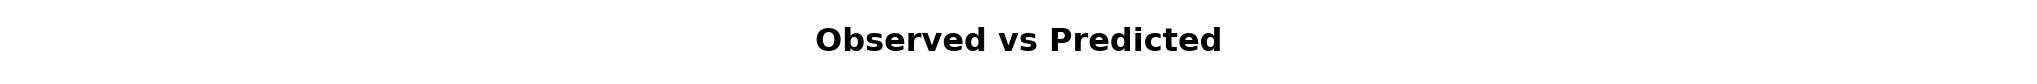

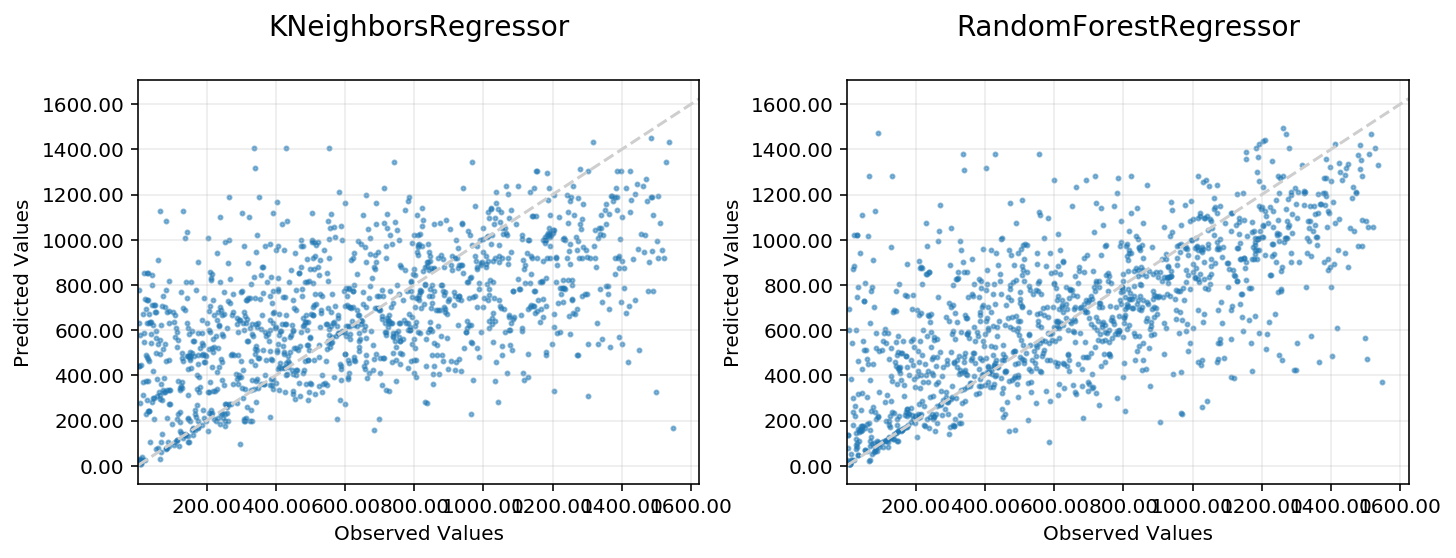

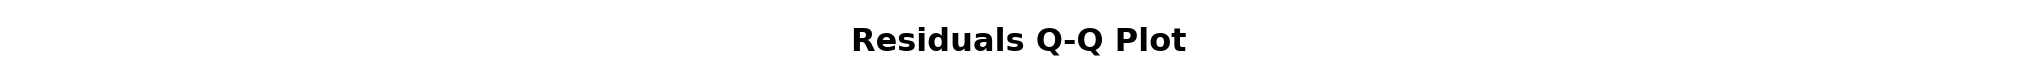

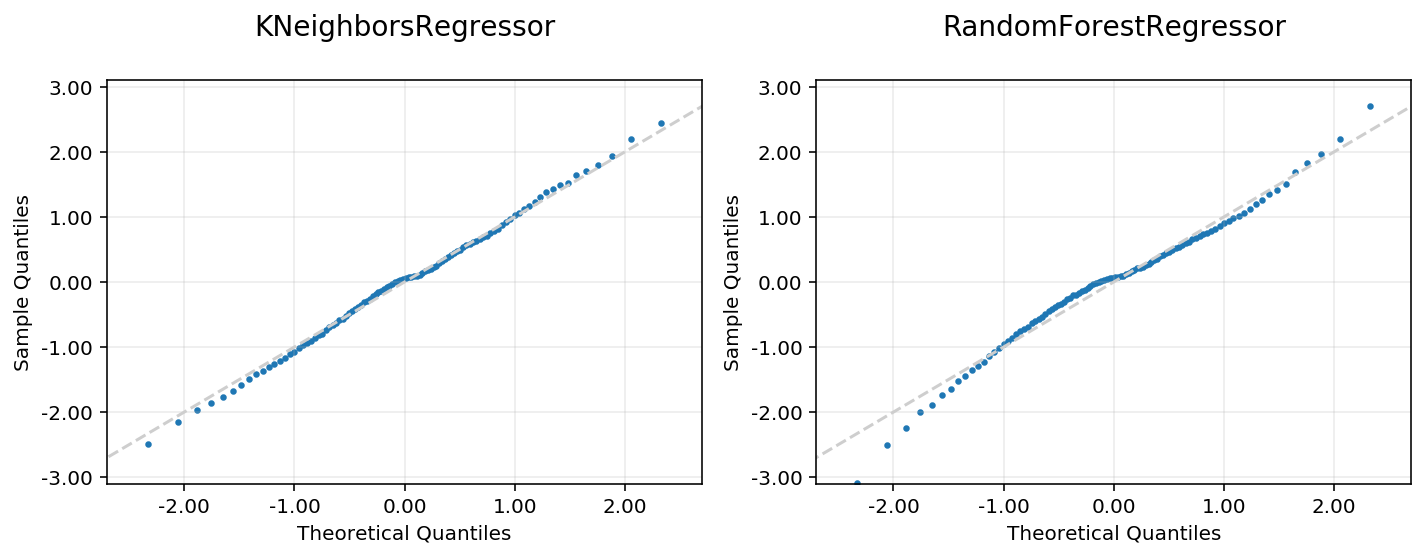

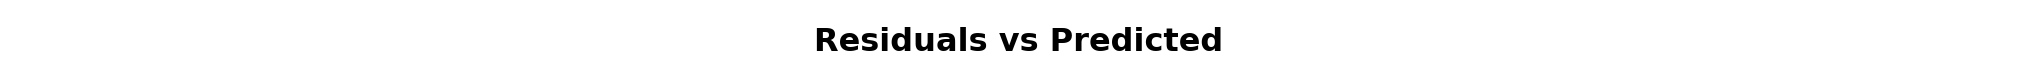

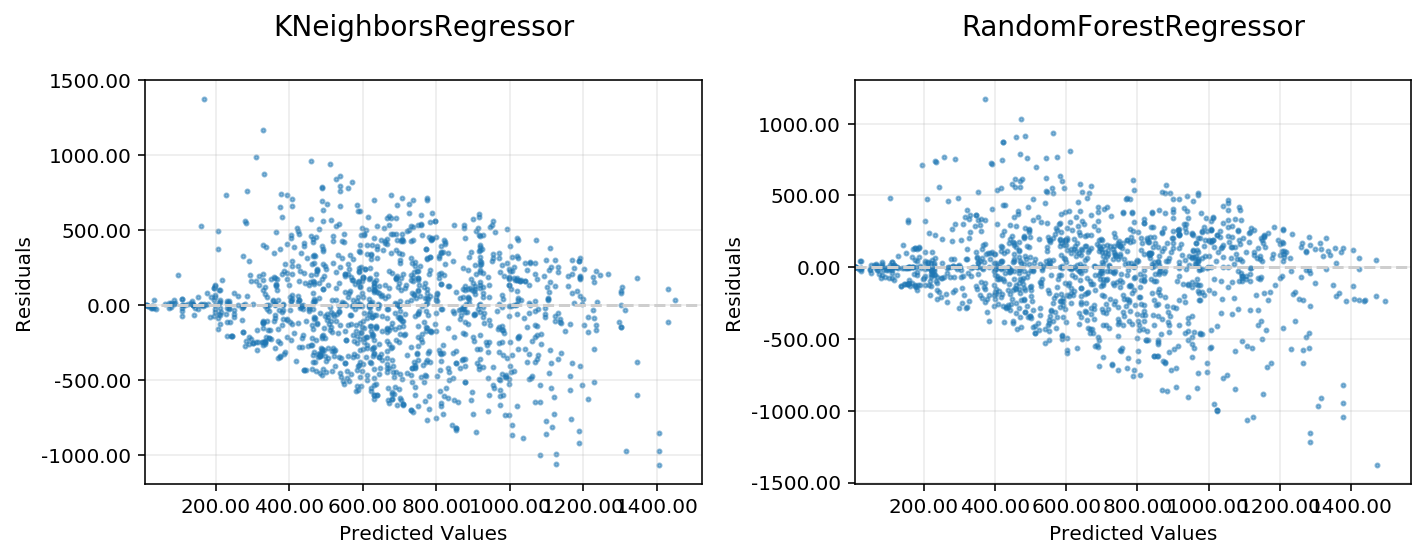

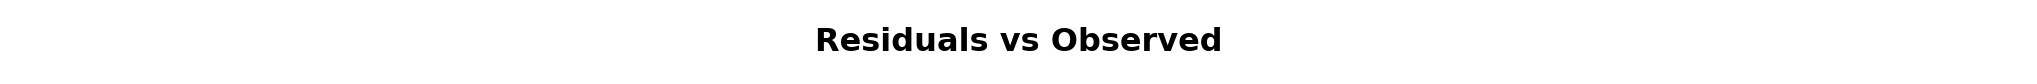

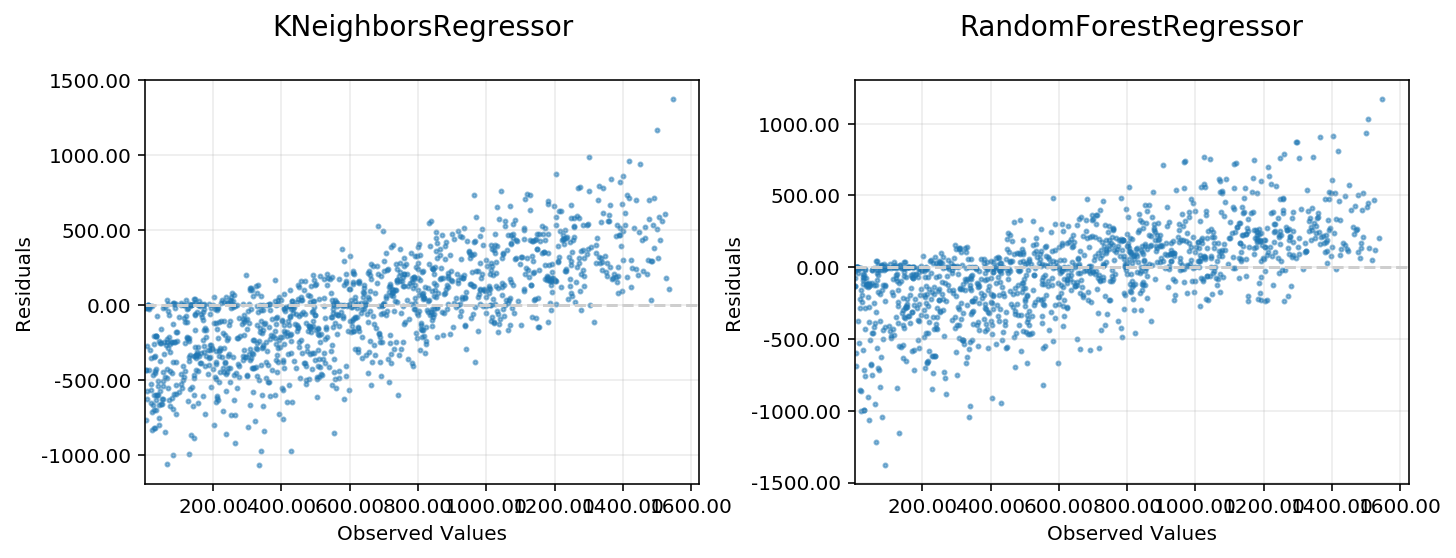

In [10]:
evaluator.show_in_notebook()

# Save the Winner Model To OCI via OCI SDK

In [208]:
model_artifact = ads_rdfr.prepare("/home/datascience/model", force_overwrite=True, fn_artifact_files_included=True)

Generated model artifact files under /home/datascience/model.


In [207]:
compartment_id = os.environ['NB_SESSION_COMPARTMENT_OCID']
project_id = os.environ['PROJECT_OCID']
mc_model = model_artifact.save(project_id=project_id, compartment_id=compartment_id, display_name="ontime-predict",
                                 description="production ready", training_script_path="getting-started.ipynb", ignore_pending_changes=True)
mc_model

,
id,ocid1.datasciencemodel.oc1.iad.amaaaaaavgi4n5aavinhd66zx4wrmq3qigu7jzoadnm4tqahv5rj53f3v7sa
compartment_id,ocid1.compartment.oc1..aaaaaaaapiwivvy56aaojhmtcc3vsz7ib36yv7yvo75lf5ogqjqs5q42n5ha
project_id,ocid1.datascienceproject.oc1.iad.amaaaaaavgi4n5aafnrqui2az2o5bzexti2zl352cyquvnswgnjt6ofskhma
display_name,ontime-predict
description,test description
lifecycle_state,ACTIVE
time_created,2020-11-20 00:20:43.044000+00:00
created_by,ocid1.user.oc1..aaaaaaaarv3qlxgxnyewp4he575l5dys4dgd7qvh2xcgei7piznul4t4r5ja
freeform_tags,{}
defined_tags,"{'Oracle-Tags': {'CreatedBy': 'oracleidentitycloudservice/zijie.fu@oracle.com', 'CreatedOn': '2020-11-20T00:20:42.895Z'}}"
